In [1]:
### Import Libraries ###

import soundfile as sf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import librosa
import librosa.display
import seaborn as sns

In [45]:
def remap(array,start,end):
    array = list(map(np.float64, array))
    size = abs(max(array)-min(array))
    new_size = abs(start-end)
    #print(size,new_size)
    scalar = new_size/size
    scaled = np.multiply(array, scalar)
    offset = start-min(scaled)
    transformed = np.add(scaled, offset)
    return transformed

def RMS(array):
    squared = np.power(array, 2)
    mean_square = sum(squared)/len(squared)
    square_root = np.sqrt(mean_square)
    return square_root

def MFCC(y, sr, n_mfcc):
    y = np.array(y)
    mfccs = librosa.feature.mfcc(y=y, sr=62500, n_mfcc=n_mfcc)
    mfcc_sum = np.array([0]*len(mfccs[0]))
    for i in range(0, len(mfccs)):
        mfcc = mfccs[i]
        normalized = remap(mfcc,0.000001,1.0)
        mfcc_sum = np.add(mfcc_sum,mfcc)
    combined = np.mean(mfcc_sum)
    #print(combined)
    return combined

def MFCCNC(y, sr, n_mfcc):
    y = np.array(y)
    mfccs = librosa.feature.mfcc(y=y, sr=62500, n_mfcc=n_mfcc)
    mfcc_sum = np.array([0]*len(mfccs[0]))
    for i in range(0, len(mfccs)):
        mfcc = mfccs[i]
        normalized = remap(mfcc,0.000001,1.0)
        mfcc_sum = np.add(mfcc_sum,mfcc)
    combined = np.mean(mfcc_sum)
    #print(combined)
    return mfcc_sum

def splitDataFrameIntoSmaller(df, chunkSize, hopSize):
    length = df.shape[0]
    window_list = []
    for i in range(0, length, int(hopSize)):
        window_list.append(df.query(str(i)+' <= index <= '+str(i+chunkSize)))
    return window_list

def splitFunc(sig,func):
    upper = []
    lower = []
    for i in range(0, len(sig)):
        if sig[i] >= 0:
            upper.append(sig[i])
            lower.append(0)
        else:
            lower.append(sig[i])
            upper.append(0)
    
    #upper = [s+1 for s in upper]
    lower_inv = np.multiply(lower, -1)
    #lower_inv = [s+1 for s in lower_inv]
    #func_upper = func(remap(upper,1,50))
    #func_lower = func(remap(lower_inv,1,50))
    func_upper = func(upper)
    func_lower = func(lower_inv)
    
    func_lower_inv = np.multiply(func_lower, -1)
    
    return np.add(func_upper, func_lower_inv)

In [52]:
data = pd.read_csv('Test.csv').filter(items=['sig']).values
data = [d[0] for d in data]
print data[:10]

[-1.52587890625e-05, 3.0517578125e-05, -4.57763671875e-05, 6.103515625e-05, -4.57763671875e-05, 1.52587890625e-05, 0.0, 0.0, 0.0, 0.0]


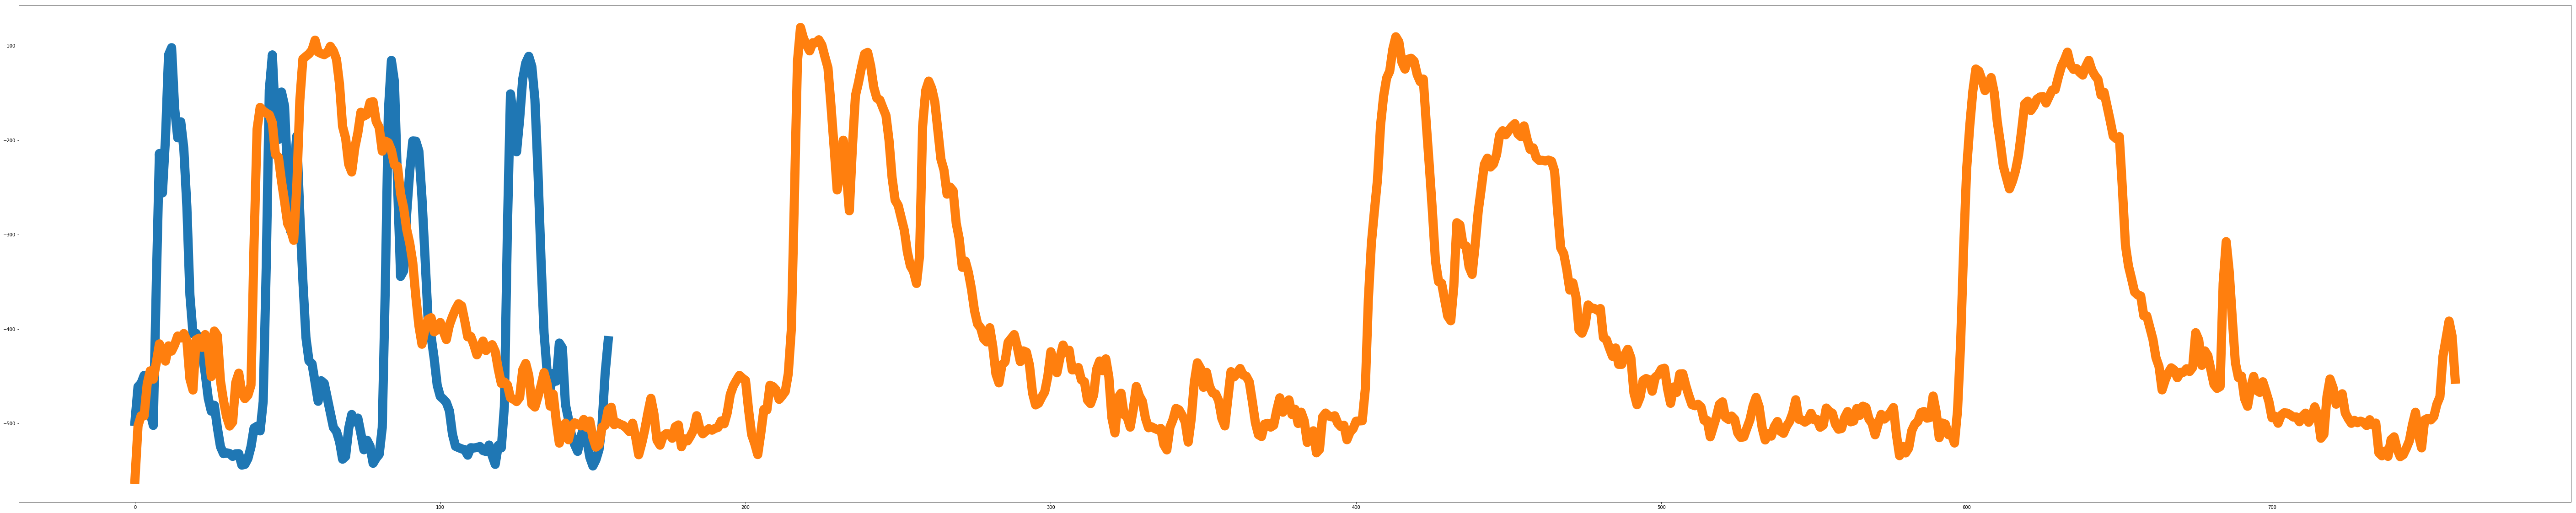

In [53]:
WIN_SIZE = 0.03
n_samples = 5000

sigs = pd.DataFrame(data)
sigs = splitDataFrameIntoSmaller(sigs,n_samples,n_samples/2)

features = []
for i in range(0, len(sigs)):
    sig = sigs[i].values
    sig = list(sig.ravel())
    #features.append([MFCC(sig,48000,1)])
    #print MFCC(sig,48000,1)
    m = MFCC(sig,48000,4).tolist()
    #features += m
    features.append(m)
features = np.array(features)

plt.figure(figsize=(100,20))
y = np.array(data)
mfcc_sum = MFCCNC(y,48000,4)
plt.plot(features,linewidth=20)
plt.plot(mfcc_sum,linewidth=20)

-0.2674560546875 -0.5171615363573552
0.378753662109375 0.6154296565078539
[-1.52587890625e-05, 3.0517578125e-05, -4.57763671875e-05, 6.103515625e-05, -4.57763671875e-05]
[-0.00390625  0.00552427 -0.00676582  0.0078125  -0.00676582]


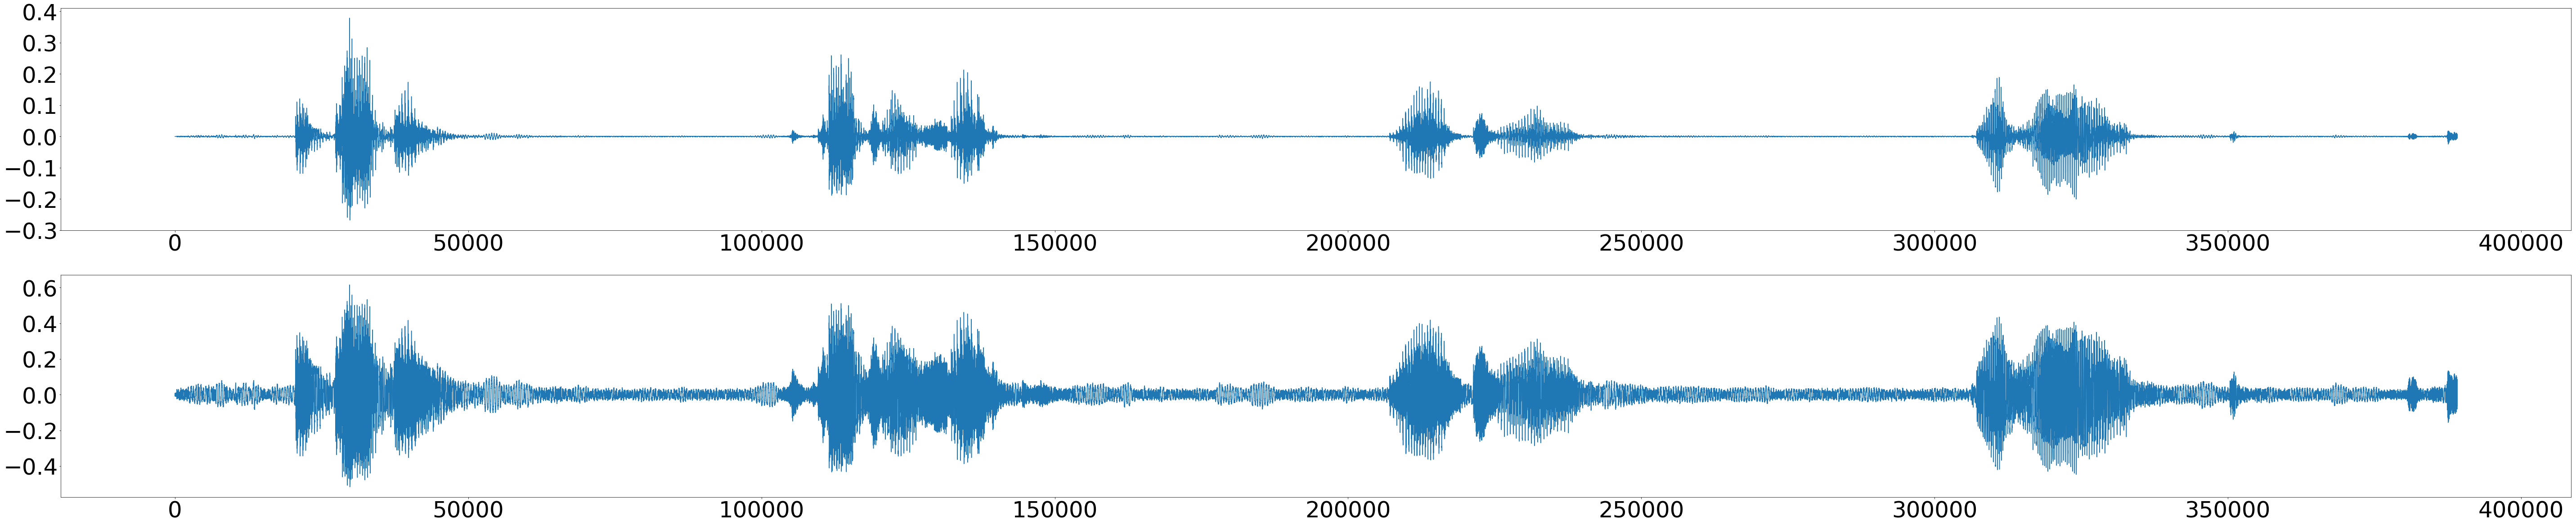

In [54]:
calc_log = splitFunc(data,np.sqrt)
#print calc_log==data

plt.figure(figsize=(100,20))

plt.subplot(2, 1, 1)
plt.xticks(fontsize=50)
plt.yticks(fontsize=50)
plt.plot(data)

plt.subplot(2, 1, 2)
plt.xticks(fontsize=50)
plt.yticks(fontsize=50)
plt.plot(calc_log)
#min, max
#print first 50
print min(data),min(calc_log)
print max(data),max(calc_log)
print data[:5]
print calc_log[:5]

Line Length: 761


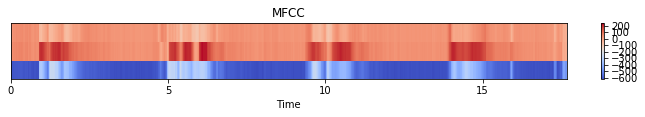

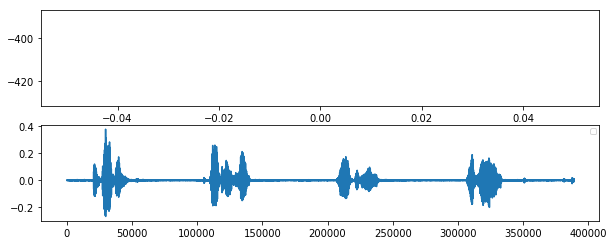

In [63]:
n_mfcc = 3
y = np.array(data)
colors = sns.color_palette("Paired", n_mfcc)
mfccs = librosa.feature.mfcc(y=y, sr=48000, n_mfcc=n_mfcc)
plt.figure(figsize=(10, 4))

plt.subplot(3,1,1)
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()

plt.title('MFCC')
plt.tight_layout()

plt.figure(figsize=(10, 6))
print "Line Length: "+str(len(mfccs[0]))

mfcc_sum = np.array([0]*len(mfccs[0]))

plt.subplot(3,1,2)

for i in range(0, len(mfccs)):
    #plt.plot(mfccs[i], label=str(i), c=colors[i])
    if i <= 4:
        mfcc = mfccs[i]
        #normalized = remap(mfcc,0.000001,1.0)
        #plt.plot(normalized, label=str(i), c=colors[i])
        mfcc_sum = np.add(mfcc_sum,mfcc)
mfcc_sum = MFCC(y,48000,n_mfcc)
plt.plot(mfcc_sum)
plt.subplot(3,1,3)
plt.plot(data)
plt.legend(fontsize='x-small')
plt.savefig("mfccs_lines.svg", format="svg")
#plt.imshow(mfccs, cmap='nipy_spectral', interpolation='nearest')

#print len(mfccs[0])
#plt.subplot(len(mfccs),1,1)
#plt.plot(mfccs[0])
#for i in range(1, len(mfccs)):
#    plt.subplot(len(mfccs),1,i+1)
#    plt.plot(mfccs[i])
#plt.show()

#12 lines, average? pick a few useful ones?
#IF pitch, maybe 1-3 & 8-12 never useful 3-6 for men and 4-8 for women

#stick to post processing

# 0,1,3,5
# 0,1,3
# 0,1
# 0,1,3
# 0,1,2,3
# 0,1
# 0,1,2,3,9
# 0,1,2,3,4
# 0,1,2,3,4,7
# 0,1,2,3
# 0,1
# 0,1,2,3,4
# 0,1,2,4
# 0,1,3,5
# 0,1,2,3,8
# 0,1,2,3
# 0,1,3
# 0,1,3,4
# 0,1

# RMS energy

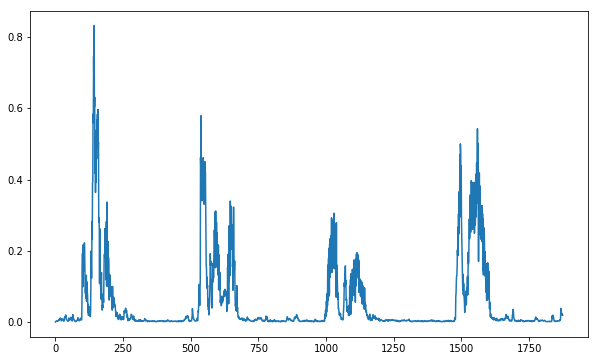

In [62]:
lbl = np.array_split(data, 0.03*62500)
rms = []
rms5 = []
for i in range(0, len(lbl)):
    sig = lbl[i]
    rms5.append(RMS(np.multiply(sig,5)))
    rms.append(RMS(sig))

plt.figure(figsize=(10, 6))
plt.plot(rms5)